# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/hepato', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)
logging.basicConfig(level=logging.INFO)

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

In [4]:
m = c14.models.liver.A()

In [5]:
from scipy.interpolate import UnivariateSpline

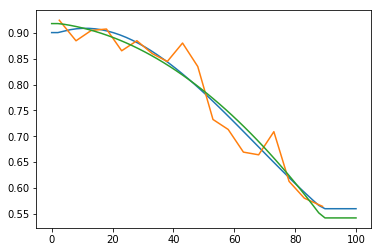

In [6]:
t = np.linspace(0, 100)
plt.plot(t, m.ploidy(t))
ploidy_data = pd.read_excel(c14.models.liver.default_path)
ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
                              mean(axis='columns'))
ploidy_data /= 100.0
ploidy_data['age'] *= 100
ploidy_data['age_min'] *= 100
ploidy_data['age_max'] *= 100

plt.plot('age', '2C_mean', data=ploidy_data)

ploidy = UnivariateSpline(ploidy_data['age'].values,
                                       ploidy_data['2C_mean'].values,
                                       ext=3, k=2)


plt.plot(t, ploidy(t))

## Data

In [7]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190722.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

## Fit the models

In [49]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'])
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [50]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [51]:
# models = c14.models.liver.models_list + c14.models.minimal.models_list
models = c14.models.liver.models_list[:9] + c14.models.liver.models_list[-2:]
models.remove(c14.models.liver.Hr40)
models.remove(c14.models.liver.Al4s)
models.remove(c14.models.liver.Akr40_d2lin)
models.remove(c14.models.liver.Ar2r4)
models.remove(c14.models.liver.Akr40q)
models.remove(c14.models.liver.Akr402x2n)
models = models[0:1]
models

[c14.models.liver.A]

In [52]:
init_limit = {'r2': (-3, 0), 
              'r4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r_0': (-3, 0),
              'r_1': (-3, 0),
              'r_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [129]:
%%time
results = fit_models(edata, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=7, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 37.6 ms, sys: 61 µs, total: 37.7 ms
Wall time: 36 ms


In [141]:
%%time
results = fit_models(edata, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 129 ms, sys: 203 µs, total: 130 ms
Wall time: 127 ms


In [142]:
# %%time
# results_C = fit_models(edata, [c14.models.liver.C], step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=1000, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [143]:
# %%time
# results_C10000 = fit_models(edata, [c14.models.liver.C], step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=10000, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [144]:
# results['C'] = results_C10000['C']

In [145]:
parameters = pd.concat(
    [result['vis'].get_parameter(result['point_estimate'], 
                                 result['cov'], 
                                 t_eval=[0, 80])
     .assign(model = name).reset_index() for name, result in results.items()
    ], ignore_index=True)

In [146]:
parameters['point_estimate'] = parameters['point_estimate'].astype(float)
parameters['lower'] = parameters['lower'].astype(float)
parameters['upper'] = parameters['upper'].astype(float)
parameters['parameter'] = parameters['parameter'].astype(str)
parameters['time'] = parameters['time'].astype(str)

In [147]:
parameters.head()

,time,parameter,point_estimate,lower,upper,model
0,0,delta2,0.458025,7.509081e-02,2.793773e+00,A
1,0,delta4,0.089455,1.898634e-02,4.214741e-01,A
2,0,kappa24,0.000023,5.109118e-03,4.408000e-02,A
3,0,kappa42,0.001004,9.051767e-22,1.114709e+15,A
4,0,lambda2,0.460058,2.049323e-01,6.835490e-01,A


In [148]:
parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
parameters['ymax'] = parameters['upper'] - parameters['point_estimate']

## Parameter Values

## Export

In [149]:
model = 'A'

In [150]:
time = np.linspace(0, 100, 101)
df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
df['r4'] = results[model]['model'].r4
df['kappa42'] = results[model]['model'].kappa42
df['delta2'] = results[model]['model'].delta2
df['delta4'] = results[model]['model'].delta4
df['age'] = time
df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
df.head()

,r2,kappa24,ratio_r,p,r4,kappa42,delta2,delta4,age,ploidy
0,0.460035,0.000023,0.152560,0.999950,0.070183,0.001004,0.458025,0.089455,0.0,0.900872
1,0.460035,0.000023,0.152560,0.999950,0.070183,0.001004,0.458025,0.089455,1.0,0.900872
2,0.460035,0.000023,0.152560,0.999950,0.070183,0.001004,0.458025,0.089455,2.0,0.900872
3,0.460013,0.000138,0.152567,0.999700,0.070183,0.001004,0.458025,0.089455,3.0,0.901836
4,0.459974,0.000369,0.152580,0.999199,0.070183,0.001004,0.458025,0.089455,4.0,0.903580


In [151]:
result = results[model]
df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

In [162]:
df = df[['time', 'point_estimate']]

In [163]:
df.to_excel('../../../results/parameters_A.xlsx')

### Detailed

A


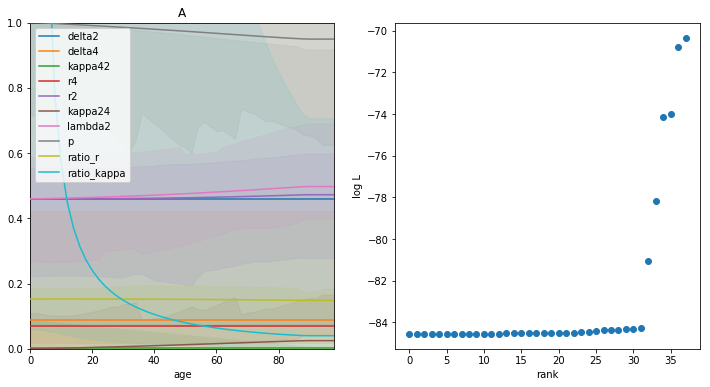

point_estimate        lower        upper
time parameter                                           
0    delta2            0.458025    0.0750908      2.79377
     delta4           0.0894553    0.0189863     0.421474
     kappa24        2.30234e-05   0.00827895     0.214436
     kappa42         0.00100449  9.05177e-22  1.11471e+15
     lambda2           0.460058     0.212258     0.606038
     p                  0.99995     0.360034      0.98235
     r2                0.460035     0.135905     0.510689
     r4               0.0701829  8.54794e-22  5.76237e+18
     ratio_kappa        43.6292     0.094539      8.84918
     ratio_r            0.15256   1.2637e-05    0.0517413
80   delta2            0.458025    0.0750908      2.79377
     delta4           0.0894553    0.0189863     0.421474
     kappa24           0.022425    0.0450256     0.201431
     kappa42         0.00100449  9.05177e-22  1.11471e+15
     lambda2            0.49221     0.354314     0.660806
     p                  0.95444     0.558941     0.881529
     r2                0.469785      0.20924     0.560948
     r4               0.0701829  8.54794e-22  5.76237e+18
     ratio_kappa      0.0447935   0.00867139      0.96378
     ratio_r           0.149394  9.69775e-05     0.116778

In [154]:
for name, result in results.items():
    if name not in ['']:
        print(name)
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
        axs[0].legend()
        axs[0].set_title(name)
        axs[0].set_ylim(0,1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('log L')
    #         axs[1].set_xlim(0, 100)

        plt.show()

        display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 80]))

### Summarized

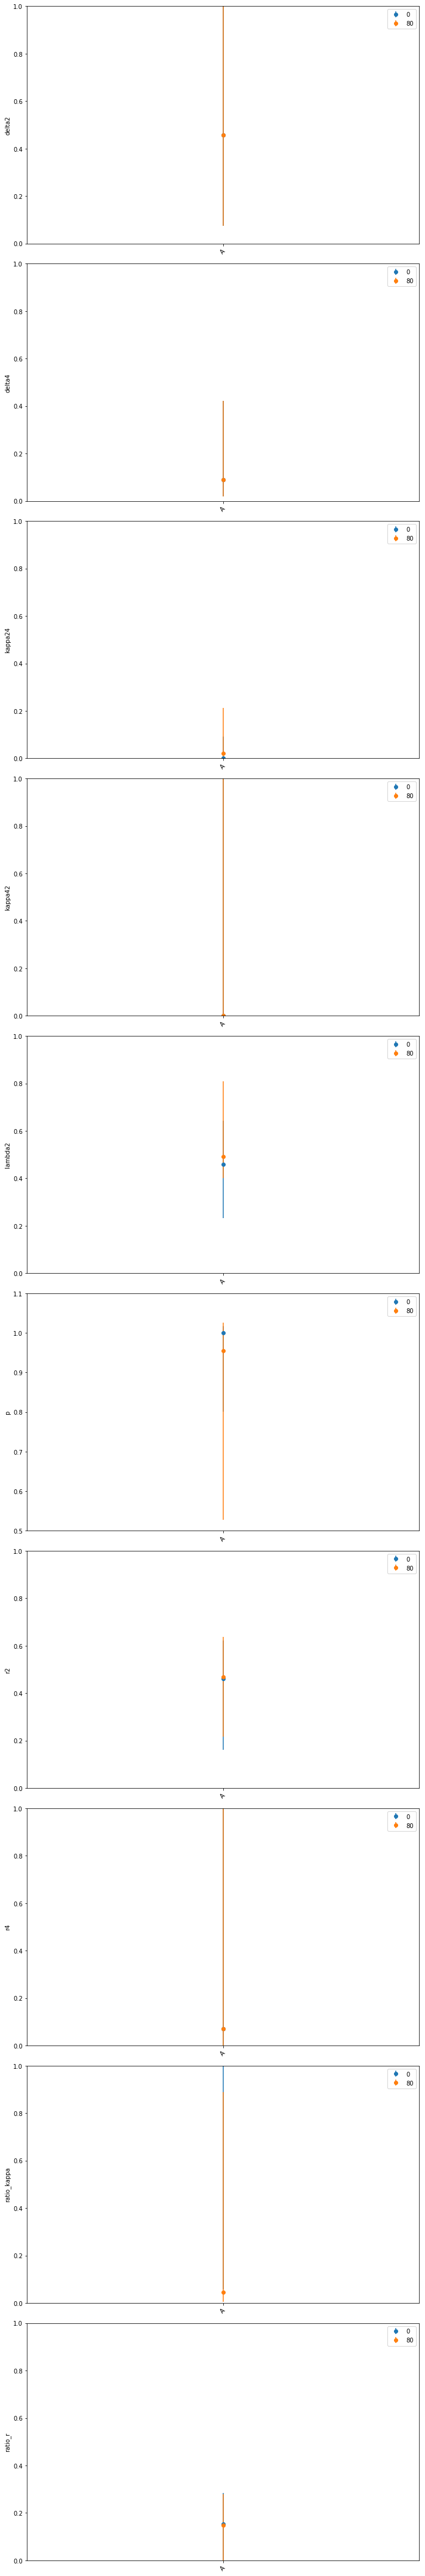

In [70]:
groupby = parameters.groupby('parameter')
fig, axs = plt.subplots(len(groupby), figsize=(10, 60))

ylimits = {'delta2': (0, 1),
           'p': (0.5, 1.1)}

for group, ax in zip(groupby, axs):
    parameter, data = group
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
    try:
        ax.set_ylim(ylimits[parameter])
    except:
        ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Model selection

In [71]:
model_selection_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
A,-156.87123,84.546726,5,0.0,1.0,1.0
